In [1]:
import numpy as np
from numpy import ndarray
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

plt.style.use("seaborn")

In [2]:
data: pd.DataFrame = pd.read_table("german.data-numeric",
                                   header=None, delim_whitespace=True)

num_cols = data.shape[1]

# Separate features from labels

X_df = data[list(range(num_cols-1))].astype(float)
y_df = data[num_cols-1] - 1  # 0 and 1 instead of 1 and 2
y_df = 2 * y_df - 1

X_df.columns += 1
X_df = (X_df - X_df.mean()) / X_df.std()

X_df.insert(0, 0, 1.)

In [3]:
X_df

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,1.0,-1.253938,-1.235859,1.343342,-0.733065,1.832252,1.337409,0.449102,1.046463,-1.293076,...,-0.195916,-0.552429,-0.338692,0.320052,-0.206664,-0.4667,0.634131,-0.149908,-0.49975,0.765973
1,1.0,-0.458797,2.247070,-0.503176,0.965893,-0.699357,-0.317800,-0.963168,-0.765594,-1.293076,...,-0.195916,-0.552429,-0.338692,0.320052,-0.206664,-0.4667,0.634131,-0.149908,-0.49975,0.765973
2,1.0,1.131486,-0.738298,1.343342,-0.414510,-0.699357,0.509805,0.449102,0.140434,-1.293076,...,-0.195916,-0.552429,-0.338692,0.320052,-0.206664,-0.4667,0.634131,-0.149908,1.99900,-1.304224
3,1.0,-1.253938,1.749509,-0.503176,1.638398,-0.699357,0.509805,0.449102,1.046463,-0.340885,...,-0.195916,-0.552429,-0.338692,-3.121368,-0.206664,-0.4667,-1.575384,-0.149908,-0.49975,0.765973
4,1.0,-1.253938,0.256825,0.420083,0.576549,-0.699357,-0.317800,0.449102,1.046463,1.563498,...,-0.195916,1.808378,-0.338692,0.320052,-0.206664,-0.4667,-1.575384,-0.149908,-0.49975,0.765973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.0,1.131486,-0.738298,-0.503176,-0.556090,-0.699357,0.509805,-0.963168,1.046463,-1.293076,...,-0.195916,-0.552429,-0.338692,0.320052,-0.206664,-0.4667,0.634131,-0.149908,1.99900,-1.304224
996,1.0,-1.253938,0.754386,-0.503176,0.222599,-0.699357,-0.317800,-2.375438,1.046463,-0.340885,...,-0.195916,-0.552429,2.949581,0.320052,-0.206664,-0.4667,0.634131,-0.149908,-0.49975,-1.304224
997,1.0,1.131486,-0.738298,-0.503176,-0.874645,-0.699357,1.337409,0.449102,1.046463,0.611307,...,-0.195916,-0.552429,-0.338692,0.320052,-0.206664,-0.4667,0.634131,-0.149908,-0.49975,0.765973
998,1.0,-1.253938,1.998289,-0.503176,-0.520695,-0.699357,-0.317800,0.449102,1.046463,1.563498,...,-0.195916,-0.552429,-0.338692,0.320052,-0.206664,-0.4667,-1.575384,-0.149908,-0.49975,0.765973


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=.333)

# Bayesian inference with Gibbs sampling

As demonstrated in the report, Gibbs sampling now boils down to the loop:
* sample $\beta^{t+1} \sim p(\beta|z^t) = \mathcal N(\mu^t, \Sigma)$ where
$$
    W = \Sigma^{-1} = \frac1\tau I_p + X^TX,
    \quad
    \mu^t = \Sigma X^Tz^t \in \mathbb R^p
$$
* sample $z^{t+1} \sim p(z|\beta^{t+1},y^t) = \exp(-\frac12\|z-X\beta\|^2) \prod_i \mathbf{1}_{\{y_iz_i > 0\}}$
* sample $y^{t+1} \sim p(y|z^{t+1}) = \mathrm{Ber}\left(\Phi(\beta_i^{t+1,T}x_i)\right)$

In [5]:
import scipy as sp
import scipy.linalg as splin
from utils import sample_truncated_gaussian

Test the truncated normal generator:

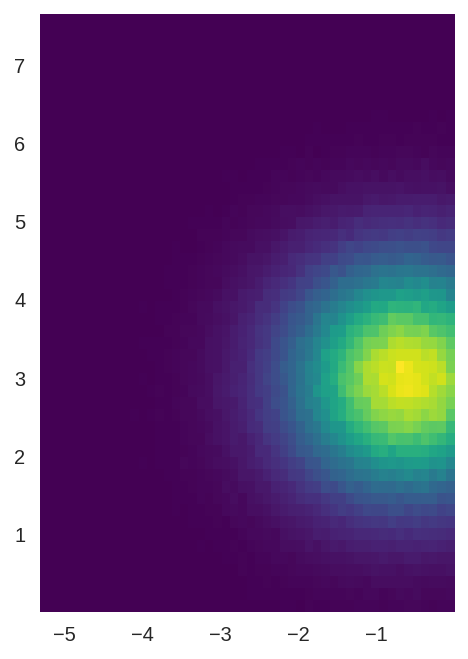

In [6]:
z_ = sample_truncated_gaussian(
    np.array([-.6, 3.]), y=np.array([-1, 1]), size=600000)
z_.shape

plt.hist2d(*z_.T, bins=50, cmap=plt.cm.viridis);
plt.axis('scaled');

In [7]:
class GibbsSampler:
    """Gibbs sampler for the graphical model."""
    def __init__(self, X: ndarray, y: ndarray, tau=100, burn_in=4000):
        self.X_train = X
        self.y_train = y
        self.n = n = X.shape[0]
        self.d = d = X.shape[1]

        self.burn_in = burn_in
        
        self.tau = tau
        
        # posterior beta|z precision matrix
        prec_ = np.eye(d) / tau + X.T @ X  # shape (d, d)
        self.cov_ = splin.pinvh(prec_)  # covariance matrix
        
        self.mu = np.zeros((d,))  # current mu
        self.mu_s = []

        self.beta = np.random.randn(d) * tau ** .5
        self.betas = []
        self.burn_betas = []  # burn in values
        
        self.z = np.random.randn(n)
        self.z_s = []
        self.burn_zs = []
    
    def reset(self):
        self.mu_s = []
        self.betas = []
        self.z_s = []
        
        self.burn_betas = []
        self.burn_zs = []
    
    def run_chain(self, num_its):
        mu = self.mu
        beta = self.beta
        z = self.z
        
        X = self.X_train
        y = self.y_train
        cov_ = self.cov_
        
        mu_op = self.cov_ @ X.T
        
        for t in range(num_its):
            ## Sample beta|z
            beta = np.random.multivariate_normal(mu, cov=cov_)
            postmean = X @ beta
            
            ## Sample z|beta,y
            z = sample_truncated_gaussian(mean=postmean, y=y)  # shape (n,)
            mu = mu_op @ z  # shape (d,)

            if t >= self.burn_in:
                self.mu_s.append(mu)
                self.betas.append(beta)
                self.z_s.append(z)
            else:
                self.burn_betas.append(beta)
                self.burn_zs.append(z)

        return np.array(self.betas), np.array(self.z_s)
    
    def predict(self, X_data, num_samples=None):
        n_data = X_data.shape[0]
        d = X_data.shape[1]
        assert d == self.d
        if num_samples is None:
            num_samples = len(self.betas)
        beta_used = np.asarray(self.betas)[-num_samples:]  # shape (num_samples, d)
        z_i = X_data @ beta_used.T  # shape (n_data, num_samples)
        z_i += np.random.randn(n_data, num_samples)  # add noise
        return np.sign(z_i).T  # return samples

In [8]:
gi_sampler = GibbsSampler(
    X_train.values, y_train.values,
    tau=100, burn_in=100)

In [9]:
import time

In [10]:
start_time = time.time()
betas_gi, zs_gi = gi_sampler.run_chain(num_its=5000 + gi_sampler.burn_in)
print("Elapsed time: %.3f" % (time.time()-start_time))

Elapsed time: 10.396


## Trace plots

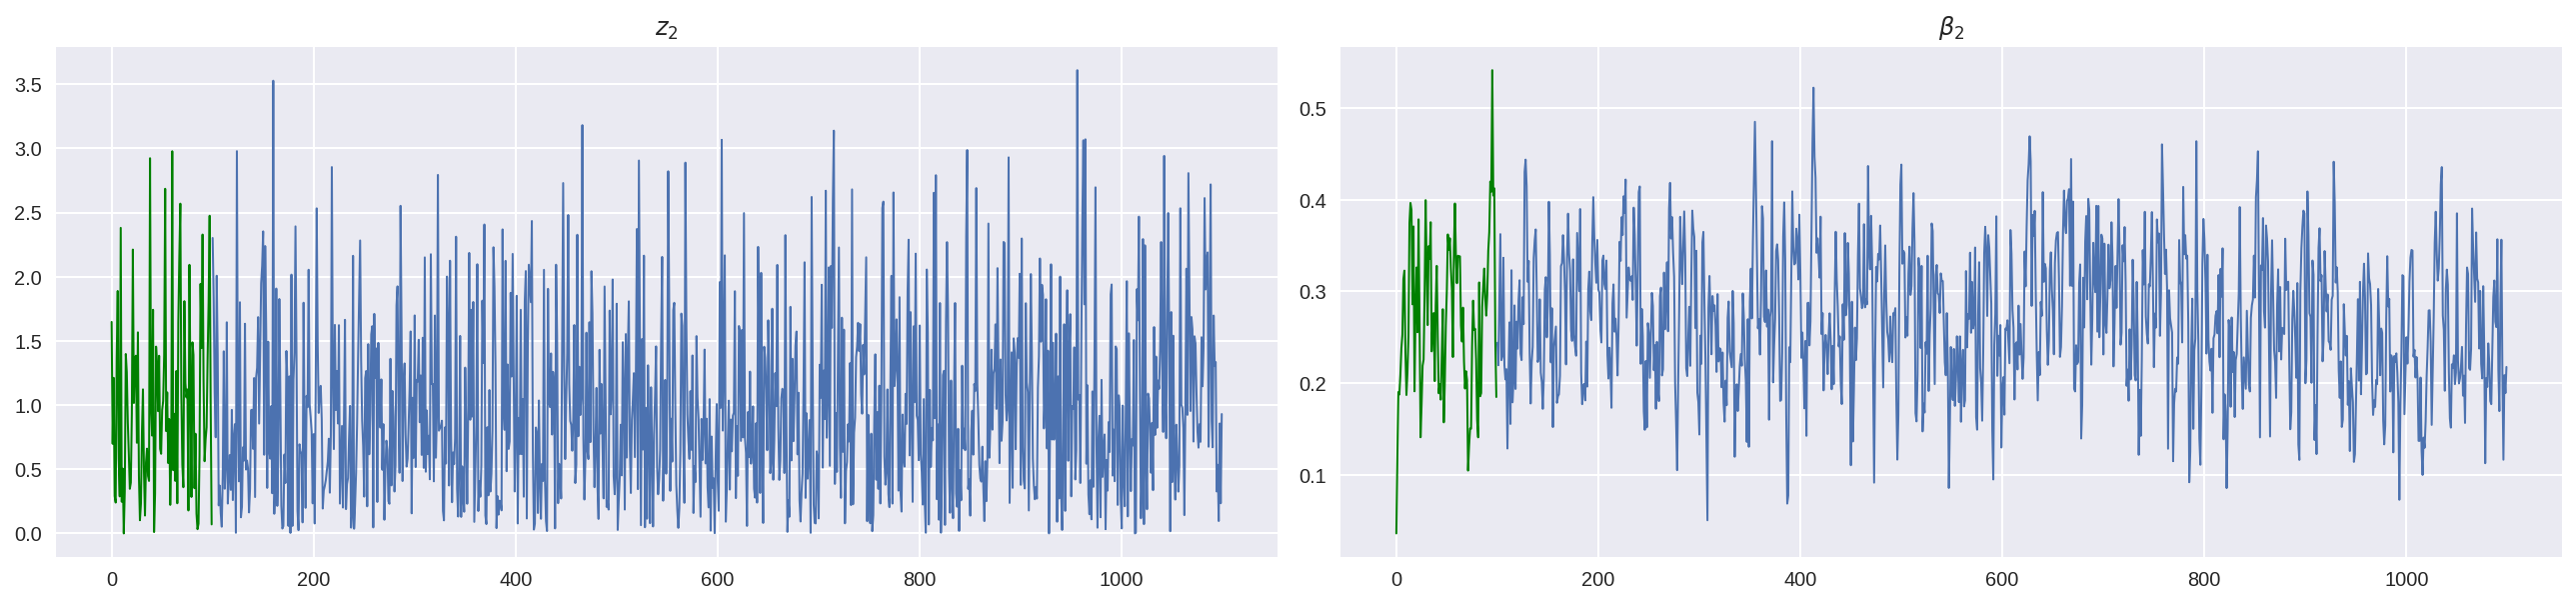

In [11]:
fig = plt.figure(figsize=(18, 8))

nrows = 2
ncols = 2

plot_ops = dict(lw=1.0)

t_max = 1000

i = 2
plt.subplot(nrows,ncols,1)
plt.title("$z_{%d}$" % i)
plt.plot(np.arange(gi_sampler.burn_in),
         np.asarray(gi_sampler.burn_zs)[:, i], c='g', **plot_ops)
plt.plot(np.arange(gi_sampler.burn_in,gi_sampler.burn_in+t_max),
         zs_gi[:t_max, i], **plot_ops)

plt.subplot(nrows,ncols,2)
plt.title("$\\beta_{%d}$" % i)
plt.plot(np.arange(gi_sampler.burn_in),
         np.asarray(gi_sampler.burn_betas)[:, i], c='g', **plot_ops)
plt.plot(np.arange(gi_sampler.burn_in,gi_sampler.burn_in+t_max),
         betas_gi[:t_max, i], **plot_ops);

fig.tight_layout()

In [12]:
fig.savefig("images/Gibbs_Markov_traceplot.png", dpi=100)

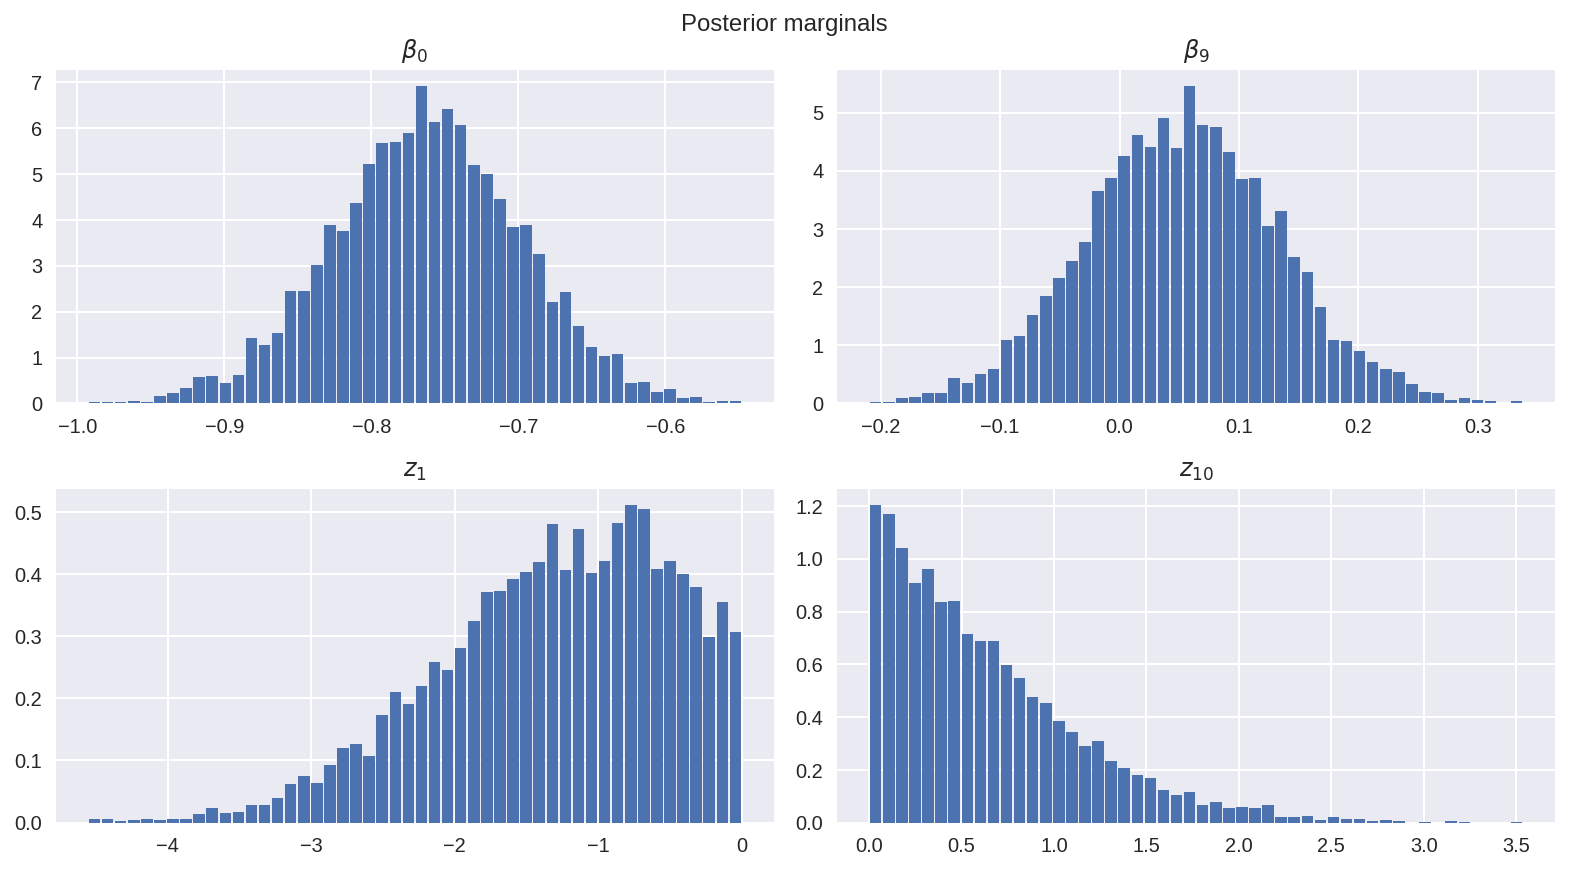

In [13]:
fig = plt.figure(figsize=(11, 6))

nrows = 2
ncols = 2

n_bins = 50

hist_opts = dict(rwidth=.88, density=True)

idx = 0
plt.subplot(nrows,ncols,1)
plt.hist(betas_gi[:, idx], bins=n_bins, **hist_opts);
plt.title("$\\beta_{%d}$" % idx)

idx = 9
plt.subplot(nrows,ncols,2)
plt.hist(betas_gi[:, idx], bins=n_bins, **hist_opts);
plt.title("$\\beta_{%d}$" % idx)

idx = 1
plt.subplot(nrows,ncols,3)
plt.hist(zs_gi[:, idx], bins=n_bins, **hist_opts);
plt.title("$z_{%d}$" % idx)

idx = 10
plt.subplot(nrows,ncols,4)
plt.hist(zs_gi[:, idx], bins=n_bins, **hist_opts);
plt.title("$z_{%d}$" % idx)

fig.tight_layout()
fig.suptitle("Posterior marginals", y=1.);

In [14]:
fig.savefig("images/posterior_distribution_gibbs.png", dpi=100)

## Prediction

We perform MAP (maximum a posteriori prediction): using the last few samples of $\beta$'s a posteriori law we compute samples of the $z_i$ of the test set, then for each one take the value with maximum probability.

In [15]:
num_samples = len(gi_sampler.betas)  # take all of the betas
y_predicts = gi_sampler.predict(X_test.values, num_samples=num_samples)

In [41]:
y_predicts.shape

(5000, 333)

Real value: -1


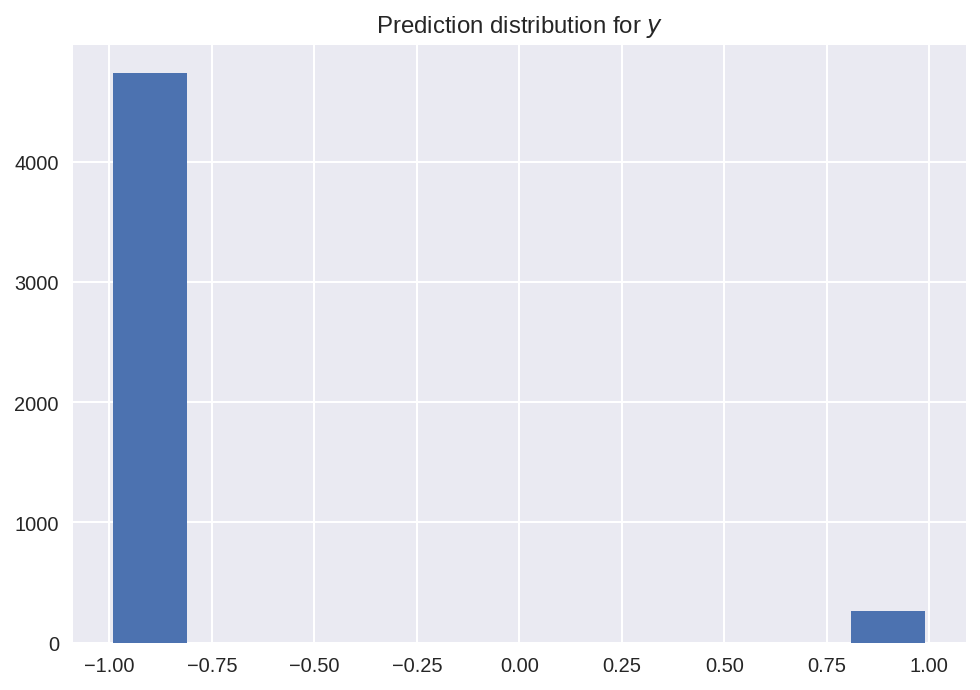

In [16]:
idx = 0

plt.hist(y_predicts[:, idx], rwidth=.9);
plt.title('Prediction distribution for $y$')

print("Real value:", y_test.iloc[idx])

In [17]:
y_ones_proba = np.mean(y_predicts == 1, axis=0)

In [18]:
y_predict_label = 2*(y_ones_proba > 0.5)-1

In [97]:
np.mean(y_predict_label == y_test.values)

0.7597597597597597

# Mean-field variational inference

The iterative coordinate ascent variational inference (CAVI) algorithm breaks down to
* update the mean $\bar{\beta}^{t+1} = \mathbb E_{\beta\sim q_1^t}[\beta]$
* update $q_2^t$ to $q_2^{t+1} = \mathrm T\mathcal N(X\bar\beta^{t+1}, I_p, (y_i))$
* update the mean $\bar{z}^{t+1}$ of $z$ under $q_2^{t+1}$
* update $q_1^t$ to $q_1^{t+1} = \mathcal N(\Sigma_p X^T\bar{z}^{t+1},\Sigma_p)$

In [22]:
from scipy.stats import norm
import time

In [23]:
class CAVI:
    """Implementation of variational inference for the probit model."""
    def __init__(self, X: ndarray, y: ndarray, tau=100):
        self.X_train = X
        self.y_train = y
        self.n = n = X.shape[0]
        self.d = d = X.shape[1]
        
        self.tau = tau
        
        # posterior beta|z precision matrix
        prec_ = np.eye(d) / tau + X.T @ X  # shape (d, d)
        self.cov_ = splin.pinvh(prec_)  # covariance of beta (q1)
        
        self.beta_bar = np.random.randn(d)  # initial beta mean
        self.z_bar = np.random.rand(n)       # initial z mean
        
        self.params = {
            "beta_mean": self.beta_bar,
            "beta_cov": self.cov_,
            "z_mean": self.z_bar
        }

        self.beta_norms = []
        self.z_norms = []
        
    def infer(self, num_its: int):
        """Compute the variational distribution."""
        cov = self.cov_
        X = self.X_train
        y = self.y_train
        n = self.n
        d = self.d
        
        for t in range(num_its):
            beta_new = cov @ (X.T @ self.z_bar)
            self.beta_norms.append(
                np.linalg.norm(beta_new - self.beta_bar, ord=1))
            self.beta_bar[:] = beta_new
            
            v = X @ self.beta_bar
            
            z_new = v + y * norm.pdf(v) / norm.cdf(y * v)
            self.z_norms.append(
                np.linalg.norm(z_new - self.z_bar, ord=1))
            self.z_bar[:] = z_new

    def sample(self, num_samples):
        """Sample from the variational distribution."""
        
        ## COMMENT: since we used a mean-field approximation,
        ## we can sample from each factor independently
        beta_mean = self.beta_bar
        betas = np.random.multivariate_normal(beta_mean,
                                              cov=self.cov_,
                                              size=num_samples)
        
        z_mean = self.z_bar
        z_s = sample_truncated_gaussian(z_mean, self.y_train,
                                        size=num_samples)
        return betas, z_s

In [24]:
vi_engine = CAVI(X_train.values, y_train.values, tau=100)

In [25]:
start_time = time.time()
vi_engine.infer(200)
print("Elapsed time: %.3f" % (time.time()-start_time))

Elapsed time: 0.215


Visualize convergence (in 1-norm, log-scale):

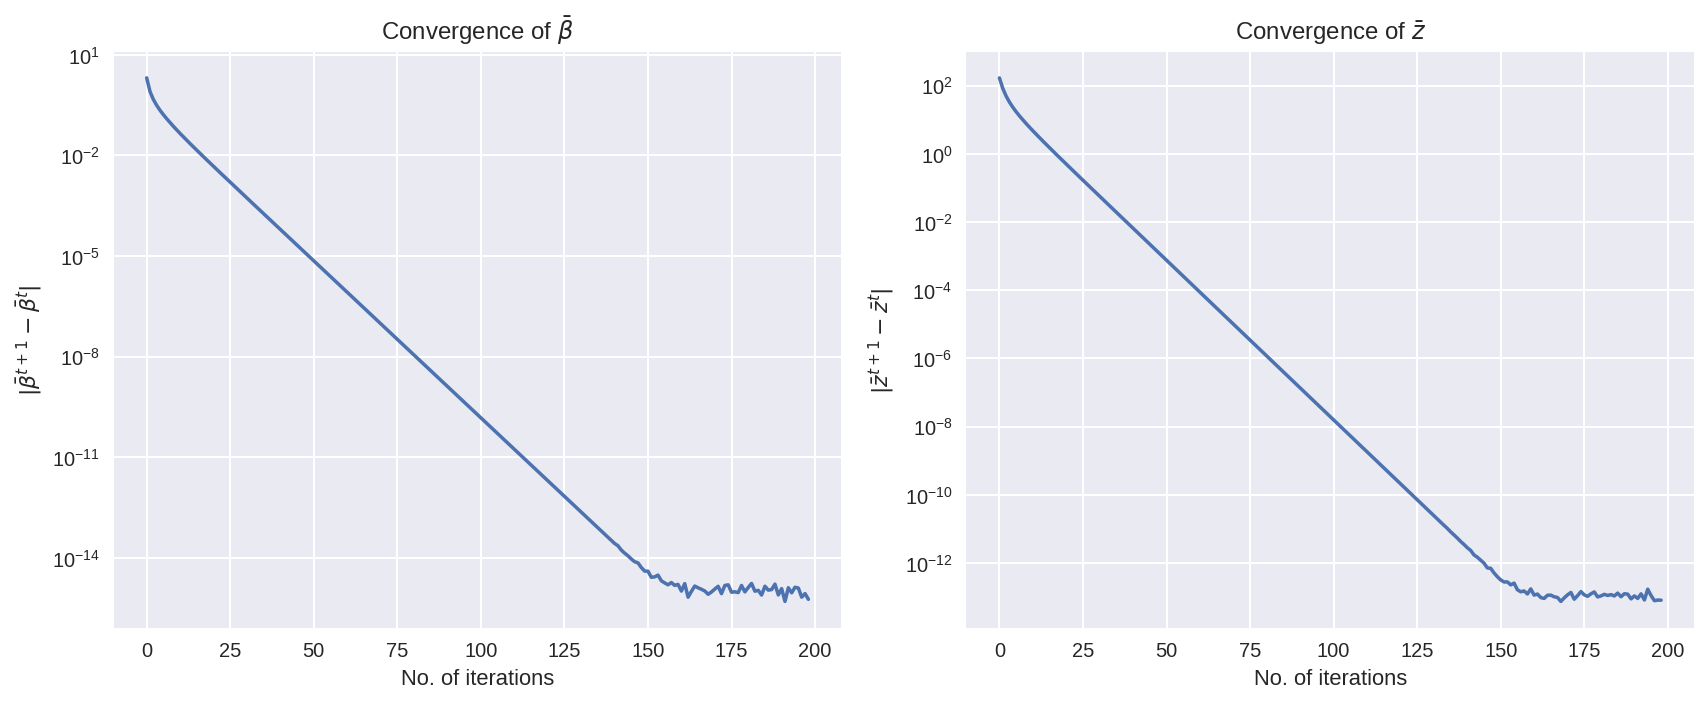

In [26]:
fig = plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plt.plot(vi_engine.beta_norms[1:])
plt.title("Convergence of $\\bar{\\beta}}$")
plt.xlabel("No. of iterations")
plt.ylabel(r"$\|\bar{\beta}^{t+1}-\bar{\beta}^{t}\|$")
plt.yscale('log')

plt.subplot(1,2,2)
plt.plot(vi_engine.z_norms[1:]);
plt.title("Convergence of $\\bar{z}$")
plt.xlabel("No. of iterations")
plt.ylabel(r"$\|\bar{z}^{t+1}-\bar{z}^{t}\|$")
plt.yscale('log');

fig.tight_layout();

In [27]:
fig.savefig("images/VI_mean_convergence.png", dpi=100)

## Sampling from the posterior

In [28]:
np.allclose(gi_sampler.cov_, vi_engine.cov_)

True

In [29]:
start_time = time.time()
betas_vi, zs_vi = vi_engine.sample(5000)
print("Elapsed time: %.3f" % (time.time()-start_time))

Elapsed time: 0.261


In [30]:
print(betas_vi.shape)
print(betas_gi.shape)

(5000, 25)
(5000, 25)


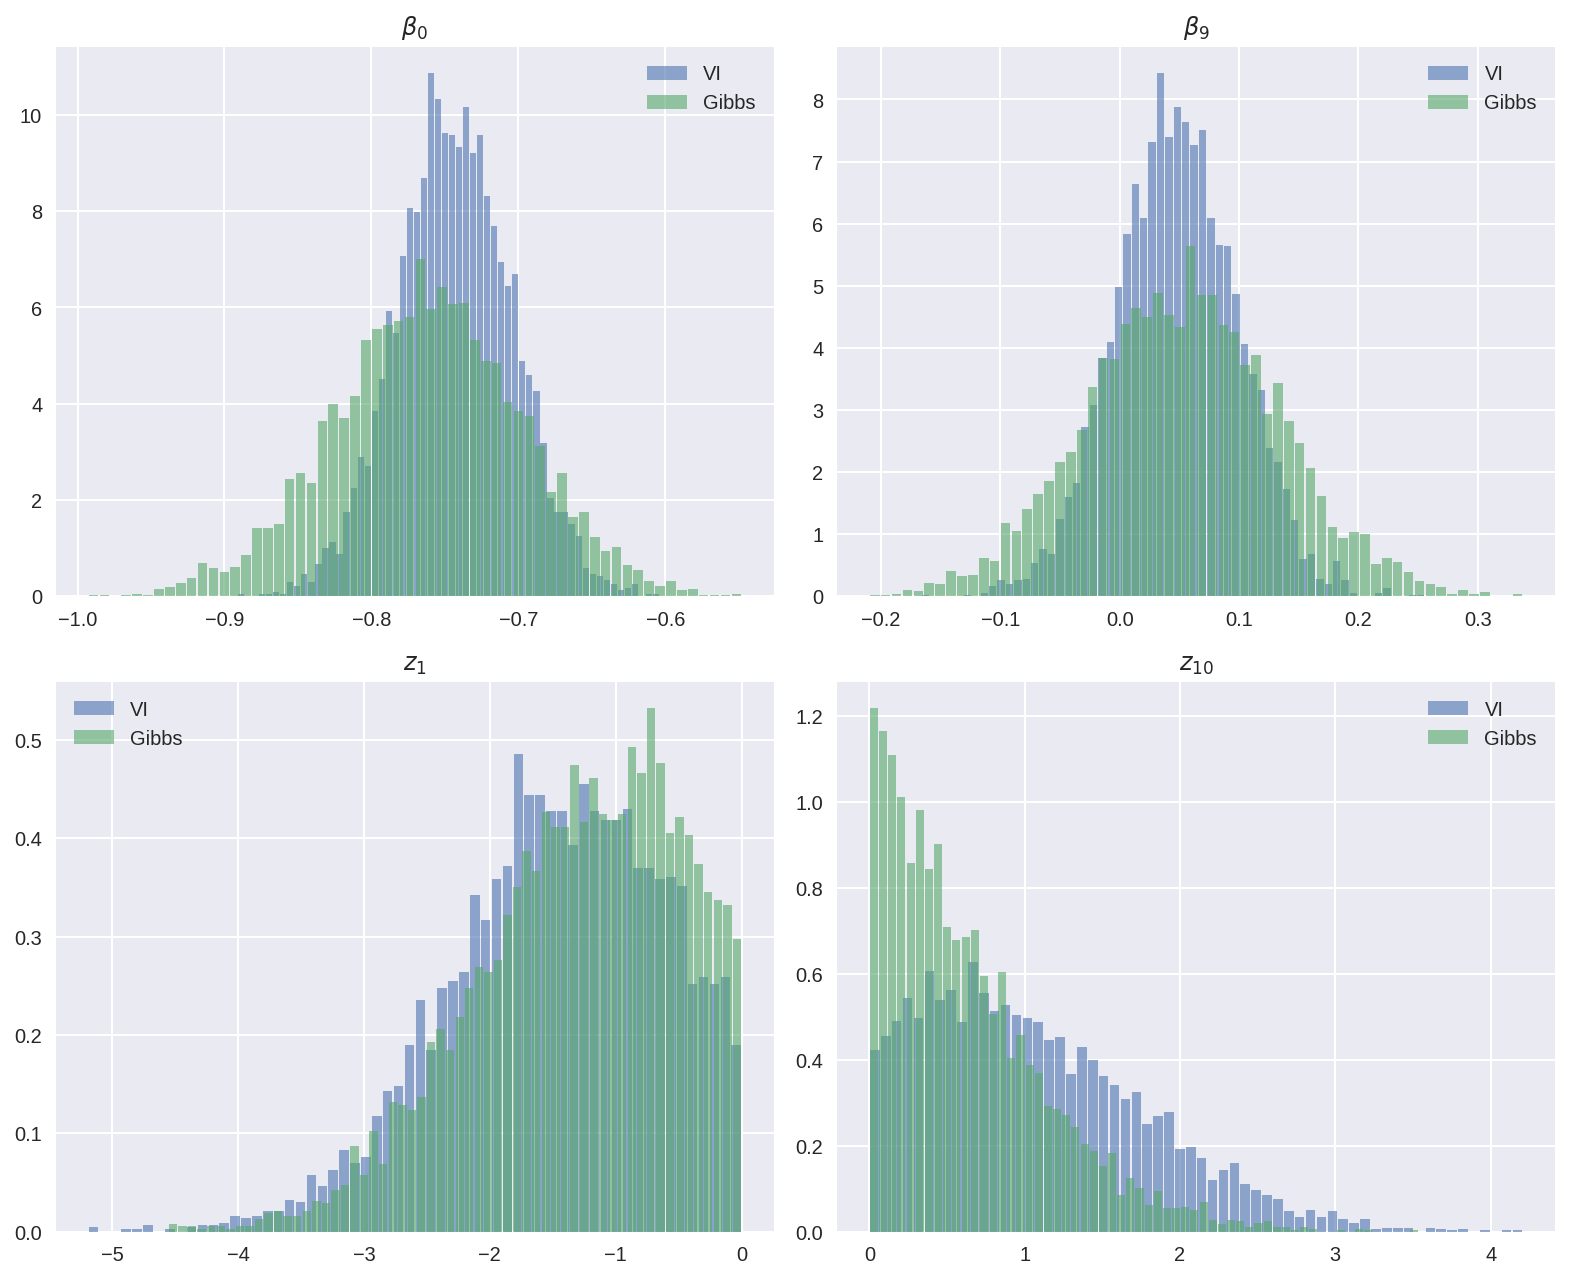

In [32]:
fig = plt.figure(figsize=(11, 9))

nrows = 2
ncols = 2

n_bins = 60

hist_opts = dict(rwidth=.88, density=True)

idx_list = [0, 9]
for k, idx in enumerate(idx_list):
    plt.subplot(nrows,ncols,k+1)
    plt.hist(betas_vi[:, idx], bins=n_bins, alpha=.6, **hist_opts, label="VI");
    plt.hist(betas_gi[:, idx], bins=n_bins, alpha=.6, **hist_opts, label="Gibbs");
    plt.legend()
    plt.title("$\\beta_{%d}$" % idx)
fig.tight_layout();


hist_opts = dict(rwidth=.88, density=True)

idx_list = [1, 10]
for k, idx in enumerate(idx_list):
    plt.subplot(nrows,ncols,k+1+2)
    plt.hist(zs_vi[:, idx], bins=n_bins, alpha=.6, **hist_opts, label="VI");
    plt.hist(zs_gi[:, idx], bins=n_bins, alpha=.6, **hist_opts, label="Gibbs");
    plt.legend()
    plt.title("$z_{%d}$" % idx)
fig.tight_layout();

In [33]:
fig.savefig("images/posterior_VI_Gibbs_comparison_1.png", dpi=100)

## Prediction

We have samples $\beta^m$ from the posterior distribution: we do MAP prediction.

In [106]:
start_time = time.time()
betas_vi, zs_vi = vi_engine.sample(10000)
print("Elapsed time: %.3f" % (time.time()-start_time))

Elapsed time: 0.407


In [107]:
def predict(beta_samp: ndarray, X: ndarray):
    n = X.shape[0]
    d = X.shape[1]
    z_ = X @ beta_samp.T  # shape (n_samples,n)
    y_ = np.sign(z_.T)
    return y_

In [108]:
y_vi_pred_samples = predict(betas_vi, X_test.values)

In [109]:
y_vi_pred_samples.shape

(10000, 333)

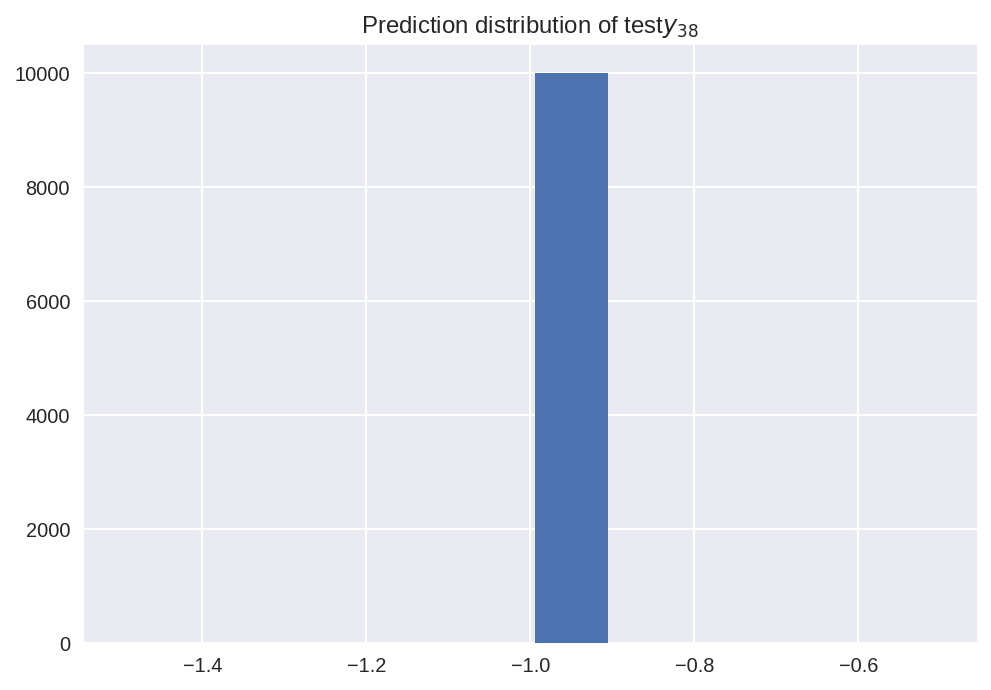

In [116]:
idx = np.random.randint(X_test.shape[0])
plt.hist(y_vi_pred_samples[:, idx], rwidth=.9);
plt.title("Prediction distribution of test"+"$y_{%d}$" % idx);

Now we get the MAP predictors:

In [111]:
y_vi_ones_prob = np.mean(y_vi_pred_samples == 1, axis=0)
y_vi_ones_prob.shape

(333,)

In [112]:
y_vi_map = 2 * (y_vi_ones_prob > 0.5) - 1

In [113]:
np.mean(y_vi_map == y_test.values)

0.7567567567567568

# Complete separation

First, let's generate some data: